# Oil Spill Analysis
In this notebook I'll explore different classification models to classify whether a section in the ocean contains an oil spill or not. First I'll use the models with no optional parameters, and then I'll try to improve on each model. Then I'll use a neural network model and compare it with the other models.

Images were processed using computer vision algorithms to provide features that describe the  contents of the image section from the ocean.

In [1]:
import os
import copy
import time

import numpy as np
from numpy.core.fromnumeric import reshape
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from numpy.random import rand

import tensorflow as tf
    
import keras
from keras import layers,Input,Sequential 
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D, MaxPooling2D
from keras.models import Model
#from tensorflow.keras.optimizers import SGD

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

2023-05-06 08:40:23.121114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

In [2]:
df = pd.read_csv("../data/oil_spill.csv")
df.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,1,2558,1506.09,456.63,90,6395000,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0


In [3]:
df.columns

Index(['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10',
       'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19',
       'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28',
       'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37',
       'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46',
       'f_47', 'f_48', 'f_49', 'target'],
      dtype='object')

These columns represent features of specific patches of an unspecified ocean captured my satellite images.

In [4]:
df.shape

(937, 50)

In [12]:
#since the target column is what we want to predict, it is our y
X = df.drop(columns = 'target')
y = df[['target']]
y

,target
0,1
1,0
2,1
3,1
4,0
...,...
932,0
933,0
934,0
935,0


In [6]:
print(X.shape)
print(y.shape)

(937, 49)
(937, 1)


In [7]:
df['target'].value_counts()

0    896
1     41
Name: target, dtype: int64

From the target column, we see that most of the patches do not contain an oil spill.

In [11]:
#check for null values
df.isnull().sum()

f_1       0
f_2       0
f_3       0
f_4       0
f_5       0
f_6       0
f_7       0
f_8       0
f_9       0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
f_31      0
f_32      0
f_33      0
f_34      0
f_35      0
f_36      0
f_37      0
f_38      0
f_39      0
f_40      0
f_41      0
f_42      0
f_43      0
f_44      0
f_45      0
f_46      0
f_47      0
f_48      0
f_49      0
target    0
dtype: int64

In [16]:
df.isnull().values.any()

False

In [13]:
#check for duplicate values
df.duplicated().sum()

0

In [14]:
#data types in dataframe
df.dtypes.value_counts()

float64    39
int64      11
dtype: int64

## Exploratory Data Analysis

In [11]:
df.describe()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
count,937.000000,937.000000,937.000000,937.000000,937.000000,9.370000e+02,937.000000,937.000000,937.000000,937.000000,...,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,81.588047,332.842049,698.707086,870.992209,84.121665,7.696964e+05,43.242721,9.127887,3940.712914,0.221003,...,933.928677,427.565582,255.435902,106.112519,5.014002,0.128068,7985.718004,61.694386,8.119723,0.043757
std,64.976730,1931.938570,599.965577,522.799325,45.361771,3.831151e+06,12.718404,3.588878,8167.427625,0.090316,...,1001.681331,715.391648,534.306194,135.617708,5.029151,0.334344,6854.504915,10.412807,2.908895,0.204662
min,1.000000,10.000000,1.920000,1.000000,0.000000,7.031200e+04,21.240000,0.830000,667.000000,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2051.500000,35.950000,5.810000,0.000000
25%,31.000000,20.000000,85.270000,444.200000,54.000000,1.250000e+05,33.650000,6.750000,1371.000000,0.160000,...,450.000000,180.000000,90.800000,50.120000,2.370000,0.000000,3760.570000,65.720000,6.340000,0.000000
50%,64.000000,65.000000,704.370000,761.280000,73.000000,1.863000e+05,39.970000,8.200000,2090.000000,0.200000,...,685.420000,270.000000,161.650000,73.850000,3.850000,0.000000,5509.430000,65.930000,7.220000,0.000000
75%,124.000000,132.000000,1223.480000,1260.370000,117.000000,3.304680e+05,52.420000,10.760000,3435.000000,0.260000,...,1053.420000,460.980000,265.510000,125.810000,6.320000,0.000000,9521.930000,66.130000,7.840000,0.000000
max,352.000000,32389.000000,1893.080000,2724.570000,180.000000,7.131500e+07,82.640000,24.690000,160740.000000,0.740000,...,11949.330000,11500.000000,9593.480000,1748.130000,76.630000,1.000000,55128.460000,66.450000,15.440000,1.000000


From calling describe we can see that each feature varies in maximum value and mean and so on.

In [12]:
df.corr()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
f_1,1.000000,-0.155581,0.172017,-0.104116,-0.017025,-0.169533,-0.037412,-0.204983,-0.244551,-0.214447,...,-0.286190,-0.167466,-0.156916,-0.141792,-0.139478,-0.163693,-0.202983,0.294422,-0.253698,-0.180531
f_2,-0.155581,1.000000,0.058390,0.052638,-0.036870,0.953947,-0.136761,-0.016822,0.829978,0.128465,...,0.555154,0.777807,0.800939,0.716496,-0.080879,-0.048315,0.118792,-0.128222,0.139417,0.034128
f_3,0.172017,0.058390,1.000000,0.549510,-0.082764,0.050795,-0.627934,-0.349541,0.158686,0.073794,...,0.186920,0.178287,0.129653,0.176883,-0.088310,-0.182458,-0.022098,0.048291,0.162600,-0.035221
f_4,-0.104116,0.052638,0.549510,1.000000,0.048847,0.024693,-0.546205,-0.222063,0.097683,0.202167,...,-0.046934,0.032402,0.022234,0.000664,-0.220461,-0.204776,0.106758,-0.394081,0.476127,-0.050489
f_5,-0.017025,-0.036870,-0.082764,0.048847,1.000000,-0.028431,0.059128,0.123814,-0.047879,0.098573,...,-0.066930,-0.014877,-0.013742,-0.012346,-0.076695,-0.080136,0.070070,-0.135294,0.116896,-0.078598
f_6,-0.169533,0.953947,0.050795,0.024693,-0.028431,1.000000,-0.093589,-0.001395,0.894150,0.097449,...,0.594273,0.844597,0.868353,0.770044,-0.077783,-0.046834,0.126850,-0.058752,0.069731,0.049318
f_7,-0.037412,-0.136761,-0.627934,-0.546205,0.059128,-0.093589,1.000000,0.381206,-0.188076,-0.380340,...,-0.115014,-0.100003,-0.074308,-0.073751,0.077207,0.088633,-0.157243,0.483034,-0.612819,-0.026183
f_8,-0.204983,-0.016822,-0.349541,-0.222063,0.123814,-0.001395,0.381206,1.000000,0.001073,0.670628,...,0.013476,-0.015712,-0.013193,0.002439,-0.061639,-0.051879,-0.028117,-0.101155,0.033731,-0.014434
f_9,-0.244551,0.829978,0.158686,0.097683,-0.047879,0.894150,-0.188076,0.001073,1.000000,0.164098,...,0.675610,0.784833,0.770129,0.736075,-0.073312,-0.048994,0.102540,-0.080203,0.113389,0.076679
f_10,-0.214447,0.128465,0.073794,0.202167,0.098573,0.097449,-0.380340,0.670628,0.164098,1.000000,...,0.082449,0.052518,0.043116,0.042269,-0.113481,-0.095896,0.112275,-0.587156,0.603358,-0.013359


Calling df.corr() helps us see which features are correlated with each other, either positively or negatively or not at all. These relationships could be important to building an accurate model. Since there are so many features, it would be easier to spot strong correlations with a heatmap.

<AxesSubplot:>

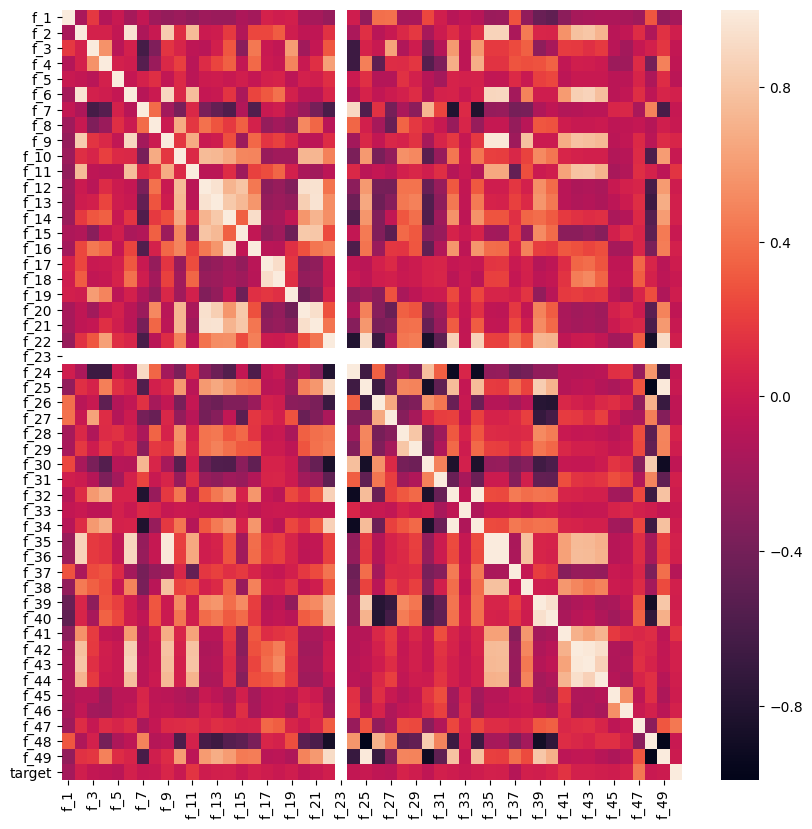

In [13]:
plt.figure(figsize=[10,10])
sns.heatmap(df.corr())

We see 2 white lines coming from the x and y axis at feature 23. That is because it only has missing values. Some negatively correlated features are features 24 and 32, 34 and 7. Some positively correlated are features 35 and 9, 36 and 9.

## Split Dataset into Train and Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((749, 49), (749, 1), (188, 49), (188, 1))

In [15]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

## Classification Models

In [16]:
#use classifier models
reg_1 = LogisticRegression(n_jobs=-1)
reg_2 = DecisionTreeClassifier()
reg_3 = LinearSVC()
reg_4 = KNeighborsClassifier()
reg_5 = RandomForestRegressor(n_estimators=500,n_jobs=-1)
reg_list = [reg_1,reg_2, reg_3, reg_4, reg_5]

In [17]:
for reg in reg_list:
    reg.fit(X_train, y_train)
    #print(reg.__class__.__name__)

In [27]:
score_dict={}

for reg in reg_list:
    reg_name=reg.__class__.__name__
    n_coeff = X_test.shape[1] + 1
    coefficients = rand(n_coeff)
    print(coefficients)
    pred = reg.predict(X_test)
    print("~"*50)
    print(reg_name)
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")
    if reg != reg_5:
        print(f"Accuracy : {accuracy_score(y_test, pred)}")
    score_dict[reg_name]={
        "R2 Score":r2_score(y_test,pred),
        "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
        "Mean Squared Error Score":mean_squared_error(y_test,pred),
        "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    }
print("~"*50)

<class 'str'>
<class 'str'>
[0.25660051 0.80799174 0.97683363 0.51929419 0.53749731 0.9669274
 0.70233396 0.74894375 0.78579095 0.75320484 0.57159907 0.1617508
 0.09250158 0.68577262 0.28645073 0.7772589  0.35345175 0.02309721
 0.10579437 0.13623438 0.73078624 0.50930312 0.98481467 0.54264139
 0.15835505 0.26057487 0.59857525 0.70185792 0.54316009 0.57187636
 0.15902664 0.02577926 0.5945303  0.31814744 0.24329321 0.17223654
 0.21777974 0.71445831 0.69456727 0.45660028 0.33828838 0.25880136
 0.56539758 0.60720222 0.43028139 0.1489286  0.06072453 0.97418599
 0.86927588 0.41663584]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticRegression
R2 Score : -0.03296703296703285
Mean Absolute Error Score : 0.031914893617021274
Mean Sqaured Error Score : 0.031914893617021274
Root Mean Squared Error: 0.1786474002526241
Accuracy : 0.9680851063829787
<class 'str'>
<class 'str'>
[0.47067178 0.09461203 0.0247102  0.40323195 0.24775013 0.82204027
 0.36119392 0.47018927 0.41960886 0.65095537 0

The accuracy was not recorded for RandomForestRegressor since classification metrics like accuracy can't handle a mix of binary and continuous targets. The accuracy scores for the models are exactly the same except for the Logistic Regresson Model.

In [19]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values("R2 Score",ascending=False)
score_pd

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
RandomForestRegressor,0.519065,0.043266,0.014859,0.121898
LinearSVC,0.139194,0.026596,0.026596,0.163082
KNeighborsClassifier,0.139194,0.026596,0.026596,0.163082
LogisticRegression,-0.032967,0.031915,0.031915,0.178647
DecisionTreeClassifier,-0.032967,0.031915,0.031915,0.178647


In [20]:
score_pd.describe()

,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
count,5.000000,5.000000,5.000000,5.000000
mean,0.146304,0.032057,0.026376,0.161071
std,0.225460,0.006807,0.006966,0.023240
min,-0.032967,0.026596,0.014859,0.121898
25%,-0.032967,0.026596,0.026596,0.163082
50%,0.139194,0.031915,0.026596,0.163082
75%,0.139194,0.031915,0.031915,0.178647
max,0.519065,0.043266,0.031915,0.178647


An R2 score measures the proportion of variance in the dependent variable, in this case the ocean patch that is predicted by the model. Since the RandomForestRegressor model is based on multiple regression trees fitting the data, it would do well with classification. The rest of the models have a R2 score close to 0, indicating that there is no linear relation for the data.

Similar to the accuracy score, every model besides the Random Forest Regressor had very similar performance metrics. More specifically, the Decision Tree, LinearSVC, and KNN models performed exaclty the same. This is evident from the table above, which shows a standard deviation less than 0.01 for average mean absolute and square score, and 0.021718 for RMSE. In the next section each of these models will be uniquely tuned to increase performance.

Overall, the models did well with an average mean absolute error score of 0.030717 and 0.025252 average mean square error.

In [30]:
# model list where models accuracy and other metrics will be stored
model_list = {}

### Random Forest Regressor

In [22]:
rf_model_1 = RandomForestRegressor(n_estimators=500, criterion="friedman_mse", n_jobs = -1, random_state=42, max_depth=4)
rf_model_2 = RandomForestRegressor(n_estimators=500, criterion="poisson", n_jobs = -1, random_state=42, max_features=13)
rf_model_3 = RandomForestRegressor(n_estimators=500, criterion="absolute_error", n_jobs = -1, random_state=42)
rf_model_1.fit(X_train, y_train)
rf_model_2.fit(X_train, y_train)
rf_model_3.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=500, n_jobs=-1,
                      random_state=42)

In [31]:
#pred = rf_model.predict(X_test)
rf_list = [rf_model_1, rf_model_2, rf_model_3]
criterion_list = ["Friedman mse", "Poisson", "Absolute Error"]
i = 0
for rf in rf_list:
    pred = rf.predict(X_test)
    print(criterion_list[i])
    i+=1
    print(f"R2 Score : {r2_score(y_test, pred)}")
    print(f"Mean Absolute Error Score : {mean_absolute_error(y_test,pred)}")
    print(f"Mean Sqaured Error Score : {mean_squared_error(y_test,pred)}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test,pred, squared=False)}")

Friedman mse
R2 Score : 0.5403473337577216
Mean Absolute Error Score : 0.04192205351897883
Mean Sqaured Error Score : 0.01420158192441625
Root Mean Squared Error: 0.11917039030067934
Poisson
R2 Score : 0.4664822956230751
Mean Absolute Error Score : 0.05779614420307951
Mean Sqaured Error Score : 0.016483740753157596
Root Mean Squared Error: 0.12838902115507228
Absolute Error
R2 Score : 0.4426915604395605
Mean Absolute Error Score : 0.0608404255319149
Mean Sqaured Error Score : 0.017218787234042552
Root Mean Squared Error: 0.13122037659617714


In [32]:
pred = rf_model_1.predict(X_test)
#
model_list["Random Forest (Friedman)"] = {
    "Accuracy" : None,
    "R2 Score" : r2_score(y_test, pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
    "Mean Squared Error Score":mean_squared_error(y_test,pred),
    "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False)
    
}

When trying different criterions and hyperparamters, we see than the model with the Friedman Mean Squared Error criterion had a higher r2 score.

### Decision Tree Classifier

[Text(0.5, 0.9166666666666666, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini 

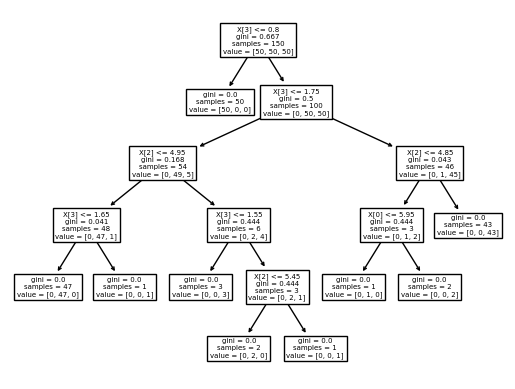

In [23]:
iris = load_iris()
clf = reg_2.fit(iris.data, iris.target)
tree.plot_tree(clf)

This is the decision tree initally made. We'll try to improve this models accuracy of 0.9521.

In [81]:
reg_2 = DecisionTreeClassifier().fit(X_train, y_train)
train_pred = reg_2.predict(X_train)
test_pred = reg_2.predict(X_test)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy : 1.0
Test Accuracy : 0.9680851063829787


Because there is a training accuracy score of 1.0 the model is certainly overfitting. The maximum depth hyperparameter should be modified to fix this.

In [82]:
dt_model_1 = DecisionTreeClassifier(max_depth=4,random_state=42, max_features=13)
dt_model_1.fit(X_train, y_train)
train_pred = dt_model_1.predict(X_train)
test_pred = dt_model_1.predict(X_test)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy : 0.9813084112149533
Test Accuracy : 0.9893617021276596


In [35]:
model_list["Decision Tree"] = {
    "Accuracy" : accuracy_score(y_test, test_pred),
    "R2 Score" : r2_score(y_test, test_pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,test_pred),
    "Mean Squared Error Score":mean_squared_error(y_test,test_pred),
    "Root Mean Squared Error": mean_squared_error(y_test,test_pred, squared=False)
    
}

### SVM (Linear SVC)

In [38]:
svm = LinearSVC(loss='hinge', random_state=42, C=0.8)
svm.fit(X_train, y_train)
train_pred = svm.predict(X_train)
test_pred = svm.predict(X_test)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy : 0.9759679572763685
Test Accuracy : 0.9840425531914894


In [39]:
model_list["SVM"] = {
    "Accuracy" : accuracy_score(y_test, test_pred),
    "R2 Score" : r2_score(y_test, test_pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,test_pred),
    "Mean Squared Error Score":mean_squared_error(y_test,test_pred),
    "Root Mean Squared Error": mean_squared_error(y_test,test_pred, squared=False)
    
}

### K-Nearest Neighbors

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy : 0.9732977303070761
Test Accuracy : 0.9787234042553191


In [41]:
model_list["KNN"] = {
    "Accuracy" : accuracy_score(y_test, test_pred),
    "R2 Score" : r2_score(y_test, test_pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,test_pred),
    "Mean Squared Error Score":mean_squared_error(y_test,test_pred),
    "Root Mean Squared Error": mean_squared_error(y_test,test_pred, squared=False)
    
}

### Logistic Regression

In [42]:
lgr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
lgr.fit(X_train, y_train)
train_pred = lgr.predict(X_train)
test_pred = lgr.predict(X_test)
print(f"Train Accuracy : {accuracy_score(y_train, train_pred)}")
print(f"Test Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy : 0.9732977303070761
Test Accuracy : 0.973404255319149


In [43]:
model_list["Logistic Regression"] = {
    "Accuracy" : accuracy_score(y_test, test_pred),
    "R2 Score" : r2_score(y_test, test_pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,test_pred),
    "Mean Squared Error Score":mean_squared_error(y_test,test_pred),
    "Root Mean Squared Error": mean_squared_error(y_test,test_pred, squared=False)
    
}

We can't record the accuracy of the Random Forest Regressor model because of its linearity, but there was an improvement in other metrics (R2 score, RMSE, and Absolute Error). For the other models, each improved a little with some hyperparameter tuning, the best of them being the Decision tree model with a test accuracy of 0.989. Now we'll create a Neural Network model with keras and compare its performance with the other models.

## Neural Network Model

In [17]:
#code based off https://www.kaggle.com/code/faiqazharabbasi/oil-spill-classification-using-neural-networks

In [46]:
model = Sequential(
    [               
        tf.keras.Input(shape=(49,)),    #specify input size
        
        Dense(500, activation='relu'),
        Dense(450, activation='relu'),
        Dense(250, activation='relu'),
        #Dense(150, activation='selu'),
        Dense(75, activation='relu'),
        Dense(2, activation='softmax'),
        
    ], name = "n_network"
)   

In [47]:
model.summary()

Model: "n_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               25000     
                                                                 
 dense_1 (Dense)             (None, 450)               225450    
                                                                 
 dense_2 (Dense)             (None, 250)               112750    
                                                                 
 dense_3 (Dense)             (None, 75)                18825     
                                                                 
 dense_4 (Dense)             (None, 2)                 152       
                                                                 
Total params: 382,177
Trainable params: 382,177
Non-trainable params: 0
_________________________________________________________________


In [48]:
#examine weights
[layer1, layer2, layer3,layer4,layer5] = model.layers
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
W4,b4 = layer4.get_weights()
W5,b5 = layer5.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")
print(f"W4 shape = {W4.shape}, b2 shape = {b4.shape}")
print(f"W5 shape = {W5.shape}, b3 shape = {b5.shape}")

W1 shape = (49, 500), b1 shape = (500,)
W2 shape = (500, 450), b2 shape = (450,)
W3 shape = (450, 250), b3 shape = (250,)
W4 shape = (250, 75), b2 shape = (75,)
W5 shape = (75, 2), b3 shape = (2,)


In [49]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics = ['accuracy']
)

acc=model.fit(
    X_train,y_train,validation_split = 0.2,epochs=10
)


Epoch 1/10
19/19 [==============================] - 2s 27ms/step - loss: 0.3459 - accuracy: 0.9382 - val_loss: 0.0828 - val_accuracy: 0.9733
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.1372 - accuracy: 0.9499 - val_loss: 0.1162 - val_accuracy: 0.9733
Epoch 3/10
19/19 [==============================] - 0s 14ms/step - loss: 0.1137 - accuracy: 0.9533 - val_loss: 0.1162 - val_accuracy: 0.9667
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0897 - accuracy: 0.9733 - val_loss: 0.0693 - val_accuracy: 0.9867
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0771 - accuracy: 0.9750 - val_loss: 0.0718 - val_accuracy: 0.9800
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0637 - accuracy: 0.9733 - val_loss: 0.0783 - val_accuracy: 0.9800
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0519 - accuracy: 0.9750 - val_loss: 0.1069 - val_accuracy: 0.9733
Epoch 8/10
19

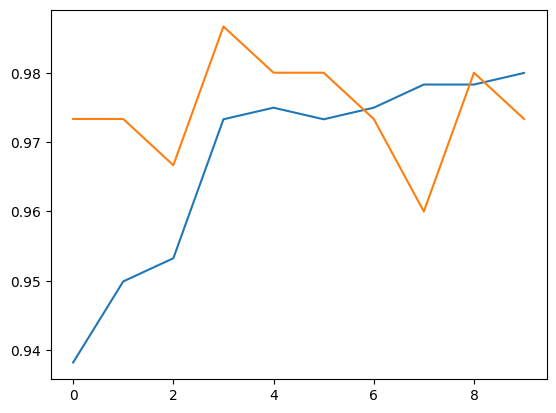

In [50]:
plt.plot(acc.history['accuracy'])
plt.plot(acc.history['val_accuracy'])

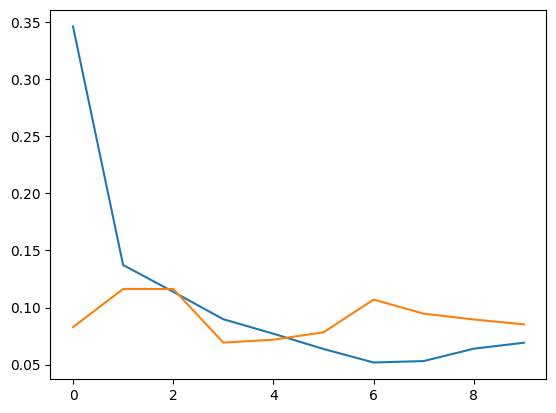

In [51]:
plt.plot(acc.history['loss'])
plt.plot(acc.history['val_loss'])

In [61]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred

6/6 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [62]:
test_accuracy = accuracy_score(y_pred,y_test)
test_accuracy

0.973404255319149

In [63]:
model_list["Neural Network"] = {
    "Accuracy" : accuracy_score(y_test, y_pred),
    "R2 Score" : r2_score(y_test, y_pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test,y_pred),
    "Mean Squared Error Score":mean_squared_error(y_test,y_pred),
    "Root Mean Squared Error": mean_squared_error(y_test,y_pred, squared=False)
    
}

Now we'll create Multilayer perceptron neural networks with sklearn to obtain a better result.
This first model will have no momentum.

In [67]:
mlp = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0, 
                    early_stopping=True,
                    max_iter=100)

In [68]:
#auxilliary fuction to fit and test models
def fit_and_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    n_iter = model.n_iter_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    loss_curve = model.loss_curve_
    return n_iter, train_score, test_score

In [69]:
n_iter, train_score, test_score = fit_and_score(mlp, X_train, X_test, y_train, y_test)

In [70]:
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 99 iterations with train score (accuracy) 0.77 and test score (accuracy) 0.71.


A test score of .71 is not horrible, and a slightly higher train score of 0.77 indicates we are probably not overfitting. Adding some momentum may help with noise in the data and improve the gradient descent.

In [71]:
mlp_momentum = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.9, 
                    early_stopping=True,
                    max_iter=100)
n_iter, train_score, test_score = fit_and_score(mlp_momentum, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 31 iterations with train score (accuracy) 0.95 and test score (accuracy) 0.96.


Here is an MLP wth Nesterov's momentum, where the decaying moving average of the gradients of projected positions in the search space is calculated.

In [72]:
mlp_momentum_n = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.9, nesterovs_momentum=True,
                    early_stopping=True,
                    max_iter=100)
n_iter, train_score, test_score = fit_and_score(mlp_momentum_n, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 31 iterations with train score (accuracy) 0.95 and test score (accuracy) 0.96.


Last, adams solver will be used instead of Stochastic Gradient Descent.

In [73]:
mlp_adam = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='adam',
                    early_stopping=True,
                    max_iter=100)
n_iter, train_score, test_score = fit_and_score(mlp_adam, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 33 iterations with train score (accuracy) 0.95 and test score (accuracy) 0.98.


We see that the adam solver MLP recorded the best test score accuracy with 0.98. Most of the models finished improving in 31 or 33 iterations, except for the base model which took 99 iterations.

In [77]:
mlp_adam.fit(X_train, y_train)
pred = mlp_adam.predict(X_test)
#test_score = mlp_adam.score(X_test, y_test)
model_list["Multi-Layer Perceptron"] = {
    "Accuracy" : accuracy_score(y_test, pred),
    "R2 Score" : r2_score(y_test, pred),
    "Mean Absolute Error Score":mean_absolute_error(y_test, pred),
    "Mean Squared Error Score":mean_squared_error(y_test, pred),
    "Root Mean Squared Error": mean_squared_error(y_test, pred, squared=False)
    
}

## Results

Here we'll add every model's performance score and compare them to each other to interpret the findings.

In [79]:
final_pd=pd.DataFrame(model_list).transpose().sort_values("Accuracy",ascending=False)
final_pd

,Accuracy,R2 Score,Mean Absolute Error Score,Mean Squared Error Score,Root Mean Squared Error
Decision Tree,0.989362,0.655678,0.010638,0.010638,0.103142
SVM,0.984043,0.483516,0.015957,0.015957,0.126323
KNN,0.978723,0.311355,0.021277,0.021277,0.145865
Multi-Layer Perceptron,0.978723,0.311355,0.021277,0.021277,0.145865
Logistic Regression,0.973404,0.139194,0.026596,0.026596,0.163082
Neural Network,0.973404,0.139194,0.026596,0.026596,0.163082
Random Forest (Friedman),NaN,0.540347,0.041922,0.014202,0.119170


The Decision Tree Classifier had the highest accuracy of 0.989, very close of 99% accuracy. It also had the highest R2 score, meaning the model fit the data best at 65.5%. It also performed the best in the rest of the categories. It is interesting to note that both the Multi-Layer Perceptron and K-nearest Neighbor models received the same scores, and the same can be said for the Logistic Regression Model and the Neural Network model.

The accuracy for the Random Forest Regressor model could not be obtained so null value was placed instead. 

Since the Decision Tree model performed the best, a confusion matrix would help visualize it in more detail.

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [88]:
y_pred = dt_model_1.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=dt_model_1.classes_)

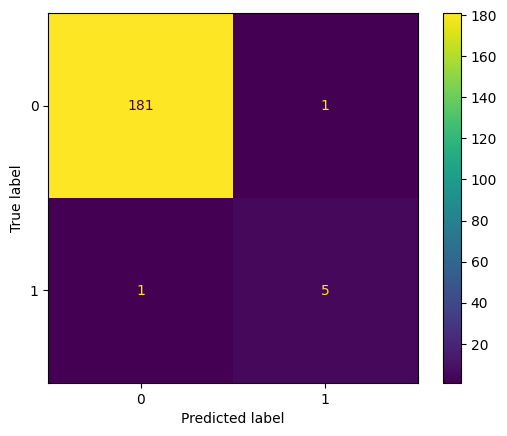

In [91]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model_1.classes_)
disp.plot()
plt.show()

In the test data, 182 patches were non spill and 6 had oil spills. Of the 182, the Decision Tree model predicted 181 to have no spills and 1 to have a spill. Of the 6 that had real spills, the model predicted 5 correctly and 1 incorrectly. In both cases the model incorrectly placed 1 instance of data. 